In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import warnings 
import math

warnings.filterwarnings('ignore')

In [10]:
%store -r xgb_model
%store -r filtered_trainDF

In [11]:
# Prepare the data: Define features (X) and target (y)
X = filtered_trainDF.drop(columns=['isFraud'])  # Features (drop the target column)
y = filtered_trainDF['isFraud']  # Target

# Handle Timestamp columns (convert them to numeric if necessary)
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in str(X[col].dtype):
        X[col] = X[col].astype('int64')  # Convert datetime to int (timestamps)

# Convert categorical columns to numeric using Label Encoding (for simplicity)
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' or isinstance(X[column].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Replace infinite or very large values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values for numeric columns with column mean, and categorical columns with mode
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:  # For numeric columns
        X[col] = X[col].fillna(X[col].mean())  # Assign the filled result back to the column
    else:  # For categorical columns, fill with the most frequent value
        X[col] = X[col].fillna(X[col].mode()[0])  # Assign the filled result back to the column
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------------------------------------------------

# Grid Search Best Estimator Analysis

In [12]:
param_grid = {
    'n_estimators': [3, 6, 9],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

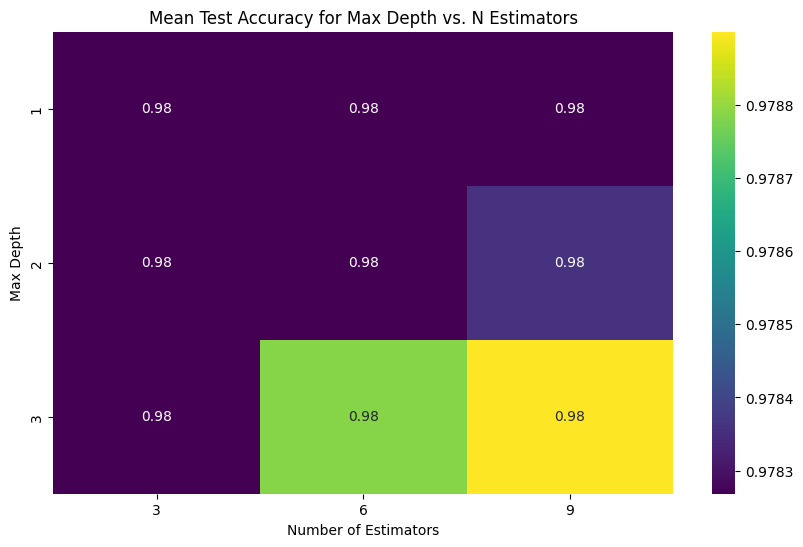

In [13]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data for a heatmap (example for 'max_depth' vs 'n_estimators')
pivot_table = results_df.pivot_table(values='mean_test_score', 
                                     index='param_max_depth', 
                                     columns='param_n_estimators')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean Test Accuracy for Max Depth vs. N Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

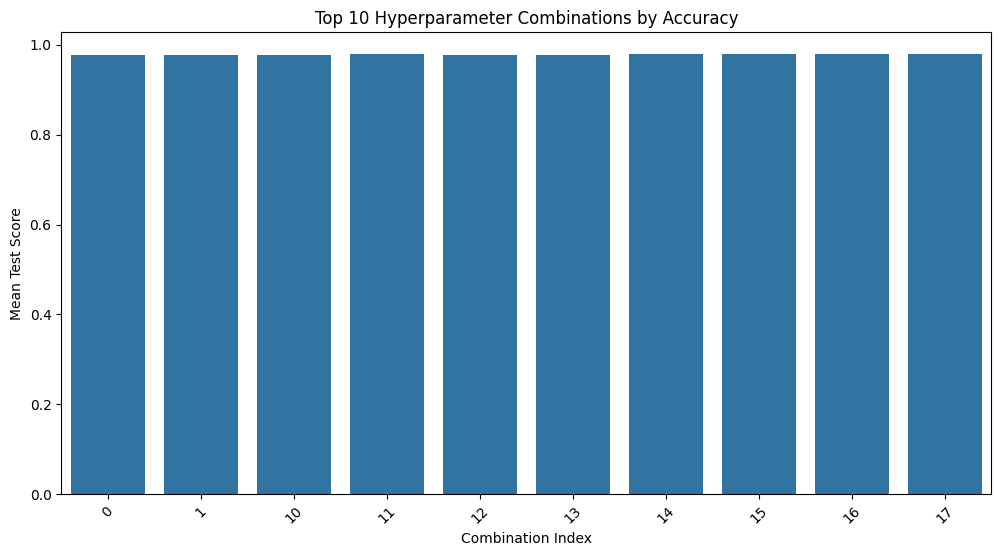

In [14]:
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_results.index, y=top_results['mean_test_score'])
plt.title('Top 10 Hyperparameter Combinations by Accuracy')
plt.ylabel('Mean Test Score')
plt.xlabel('Combination Index')
plt.xticks(rotation=45)
plt.show()

# --------------------------------------------------------------------------------------

# Top 10 Features Analysis

In [15]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n).index

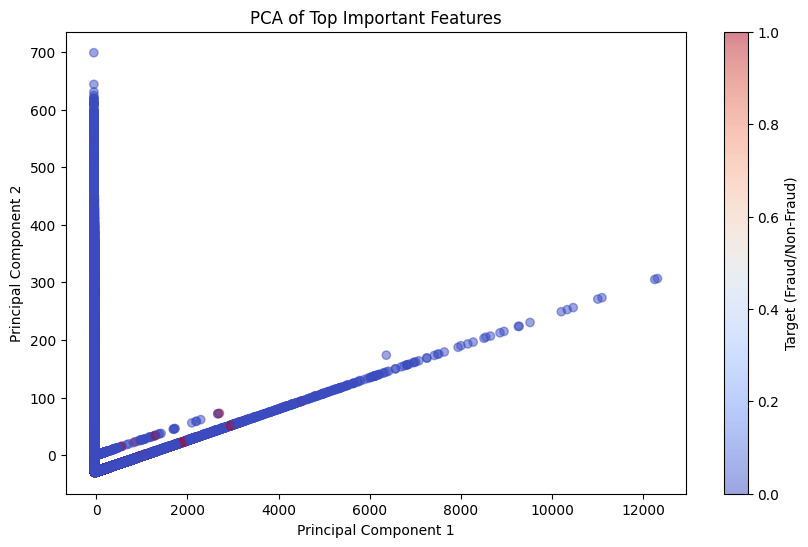

In [16]:
X_reduced = X[top_features]
pca = PCA(n_components=2)  # Change the number of components as needed
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Top Important Features')
plt.colorbar(label='Target (Fraud/Non-Fraud)')
plt.show()

In [17]:
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]
grid_search_top_features = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_top_features.fit(X_train_top_features, y_train)

best_model_top_features = grid_search_top_features.best_estimator_
y_pred = best_model_top_features.predict(X_test_top_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the tuned model using top 10 features: {accuracy:.4f}")

Accuracy of the tuned model using top 10 features: 0.9788


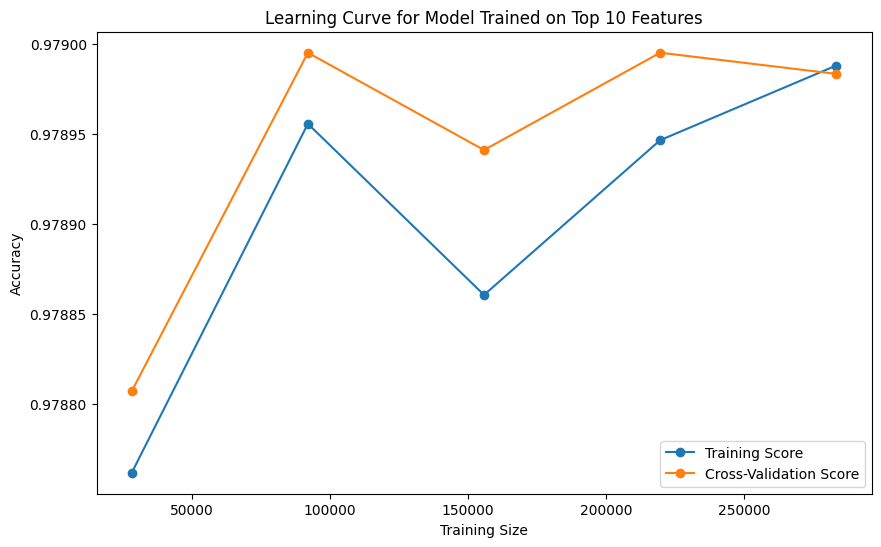

In [18]:
train_sizes, train_scores, test_scores = learning_curve(best_model_top_features, 
                                                        X_train_top_features, 
                                                        y_train, cv=3, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve for Model Trained on Top 10 Features')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Accuracy of XGBoost on combined data: 0.9802


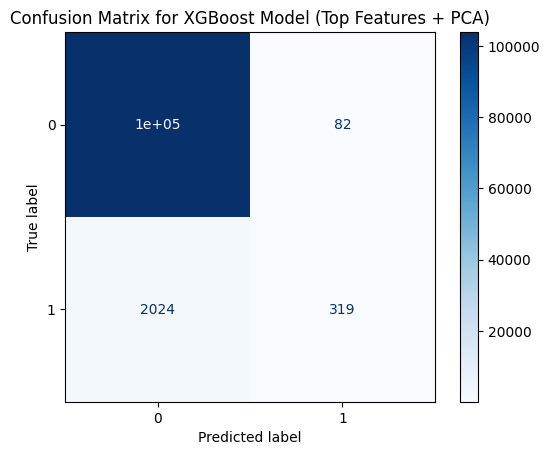

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Combine original top features and PCA components
X_combined = np.hstack([X_reduced, X_pca])

# Split the data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model_combined = XGBClassifier()
xgb_model_combined.fit(X_train_combined, y_train)

# Generate predictions
y_pred_combined = xgb_model_combined.predict(X_test_combined)

# Calculate accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f'Accuracy of XGBoost on combined data: {accuracy_combined:.4f}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_combined.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model (Top Features + PCA)')
plt.show()

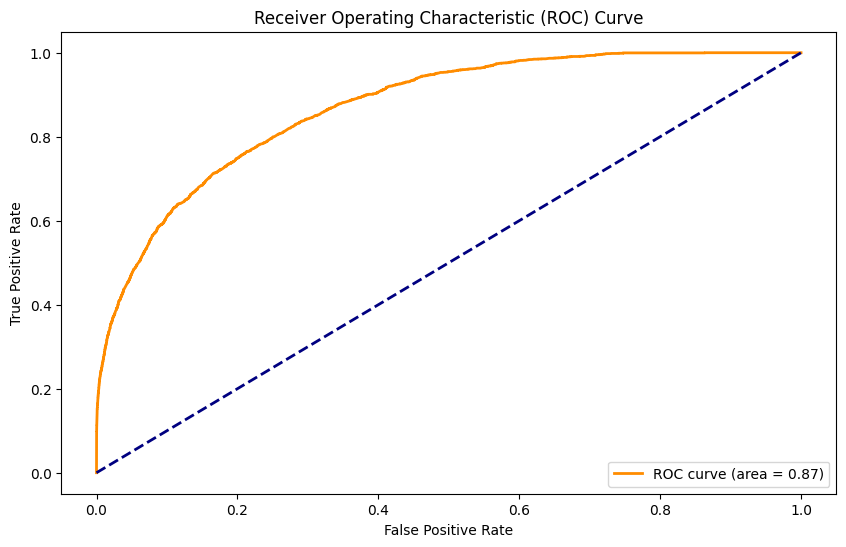

In [20]:
y_prob = xgb_model_combined.predict_proba(X_test_combined)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

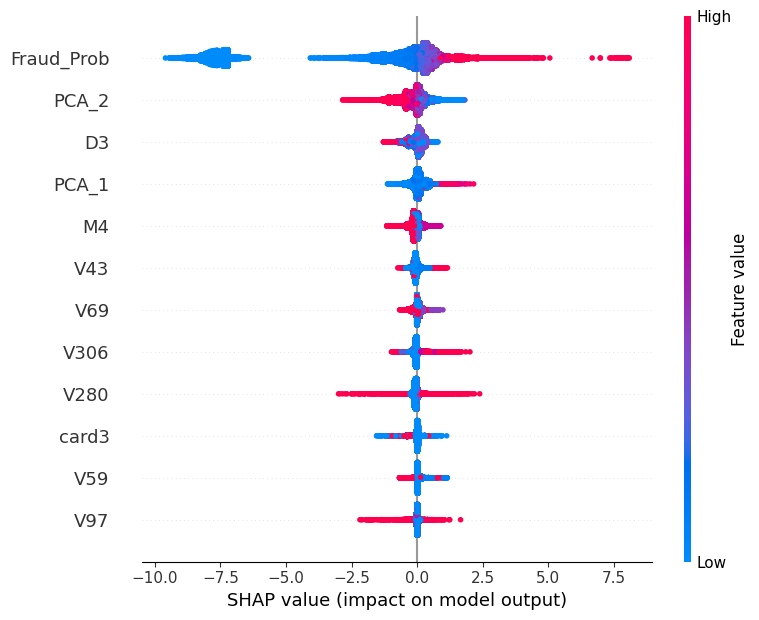

In [21]:
X_test_combined_df = pd.DataFrame(X_test_combined, columns=list(top_features) + ["PCA_1", "PCA_2"])

# Re-run the SHAP explainer with the DataFrame that includes column names
explainer = shap.TreeExplainer(xgb_model_combined)
shap_values = explainer.shap_values(X_test_combined_df)

# Summary plot with labeled features
shap.summary_plot(shap_values, X_test_combined_df)

# --------------------------------------------------------------------------------------

# Ensemble Method: Stacking + Blending

In [22]:
estimators = [
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression())
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_combined, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

Accuracy: 0.9802
Precision: 0.7153
Recall: 0.1694
F1 Score: 0.2740
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    103955
           1       0.72      0.17      0.27      2343

    accuracy                           0.98    106298
   macro avg       0.85      0.58      0.63    106298
weighted avg       0.98      0.98      0.97    106298



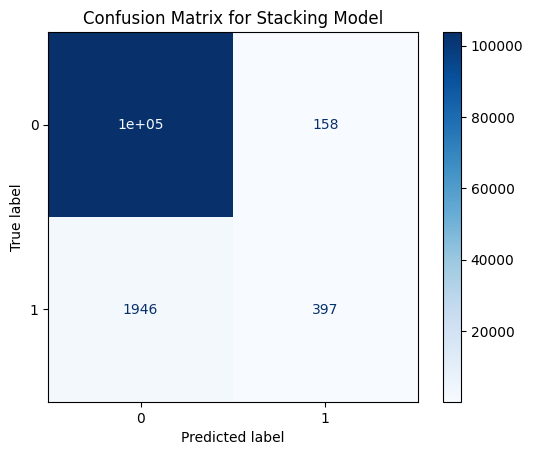

In [23]:
y_pred = stacking_model.predict(X_test_combined)
y_prob = stacking_model.predict_proba(X_test_combined)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

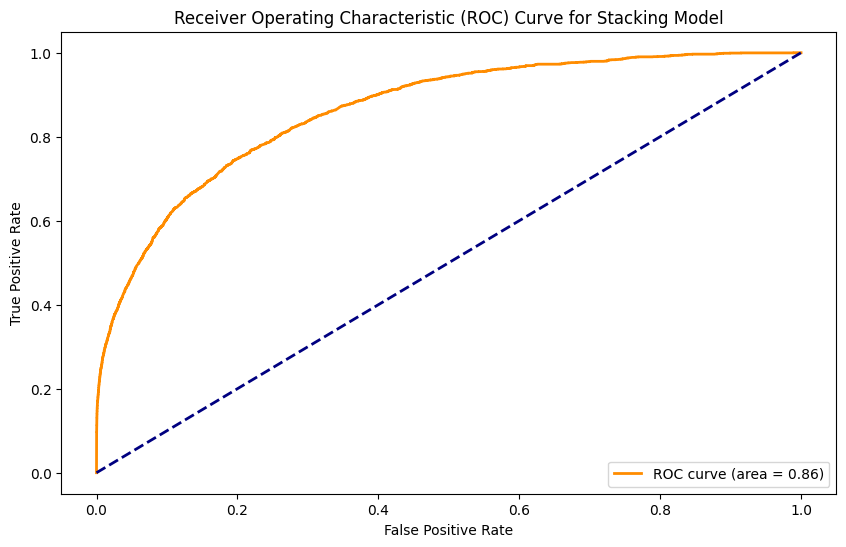

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Model')
plt.legend(loc='lower right')
plt.show()

# --------------------------------------------------------------------------------------

# Voting Model

In [25]:
# voting_model = VotingClassifier(
#     estimators=estimators,
#     voting='soft',
#     weights=[0.4, 0.3, 0.3]  # Example weights for XGBoost, Random Forest, Logistic Regression
# )

# # Fit the model
# voting_model.fit(X_train_combined, y_train)

In [26]:
# y_pred = voting_model.predict(X_test_combined)
# y_prob = voting_model.predict_proba(X_test_combined)[:, 1]
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# print("Classification Report:\n", classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_model.classes_)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix for Voting Model')
# plt.show()

In [27]:
# weight_options = [
#     [0.5, 0.3, 0.2],
#     [0.6, 0.2, 0.2],
#     [0.4, 0.4, 0.2]
# ]

# best_score = 0
# best_weights = None

# # Iterate through different weight options
# for weights in weight_options:
#     voting_model.set_params(weights=weights)
#     scores = cross_val_score(voting_model, X_train_combined, y_train, cv=5, scoring='accuracy')
#     mean_score = scores.mean()
#     if mean_score > best_score:
#         best_score = mean_score
#         best_weights = weights

# print(f"Best Weights: {best_weights} with Accuracy: {best_score:.4f}")

# --------------------------------------------------------------------------------------

# Repeated Nested Cross Validation

Repeated Nested CV Accuracy: 0.9802 ± 0.0002
Repeated Nested CV Precision: 0.8416 ± 0.0250
Repeated Nested CV Recall: 0.1090 ± 0.0078
Repeated Nested CV F1 Score: 0.1929 ± 0.0124
Repeated Nested CV ROC-AUC Score: 0.8585 ± 0.0045
Final Model Accuracy: 0.9802
Final Model Precision: 0.8882
Final Model Recall: 0.1187
Final Model F1 Score: 0.2093
Final Model ROC-AUC Score: 0.8633


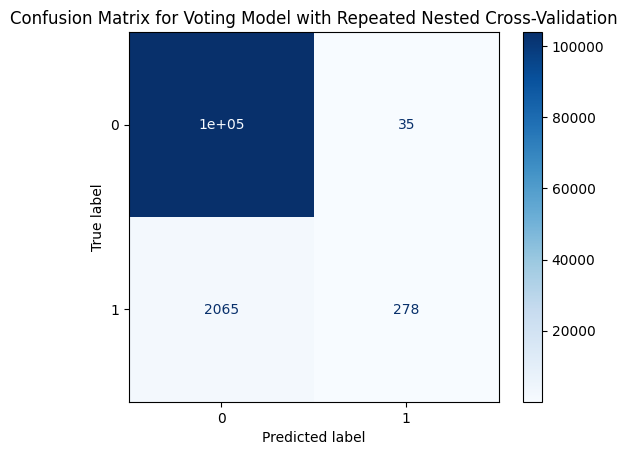

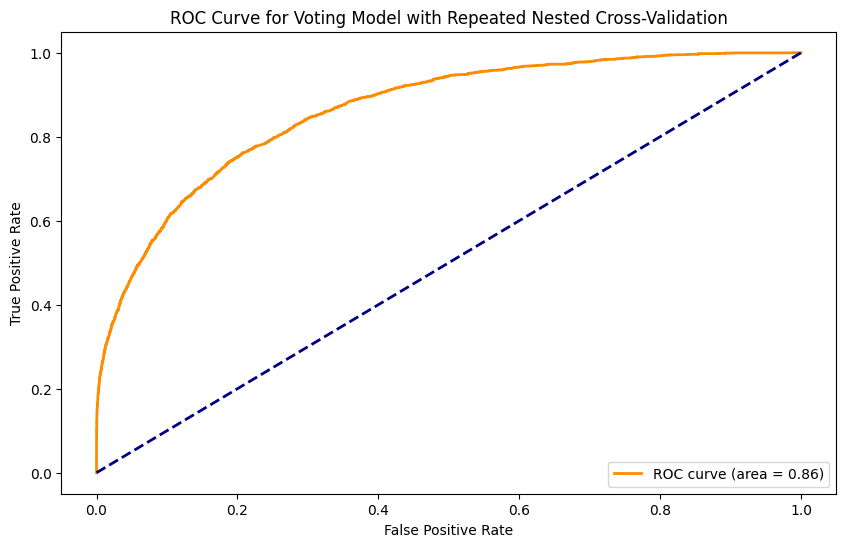

In [28]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Define base estimators for the ensemble
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(random_state=42)

# Outer loop: Repeated Stratified K-Fold for model evaluation
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Initialize lists to store performance metrics
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []

X_train_combined = np.array(X_train_combined)
y_train = np.array(y_train)

# Repeated Nested Cross-Validation
for train_index, test_index in outer_cv.split(X_train_combined, y_train):
    # Split data into outer training and test sets
    X_outer_train, X_outer_test = X_train_combined[train_index], X_train_combined[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]



    # Inner loop: Grid Search with inner cross-validation
    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1)

    # Fit Grid Search on the outer training data
    grid_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = grid_search.best_estimator_

    # Define the Voting Classifier with the best XGBoost model
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]

    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[0.5, 0.3, 0.2]
    )

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Make predictions on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]

    # Evaluate the model performance on the outer test set
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred))
    outer_recall.append(recall_score(y_outer_test, y_pred))
    outer_f1.append(f1_score(y_outer_test, y_pred))
    outer_roc_auc.append(roc_auc_score(y_outer_test, y_prob))

# Print the averaged metrics from the outer loop
print(f"Repeated Nested CV Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Repeated Nested CV Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Repeated Nested CV Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"Repeated Nested CV F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")
print(f"Repeated Nested CV ROC-AUC Score: {np.mean(outer_roc_auc):.4f} ± {np.std(outer_roc_auc):.4f}")

# Final model training on the entire dataset using the best features and parameters
voting_model.fit(X_train_combined, y_train)

# Evaluate the final model on the independent test set
y_final_pred = voting_model.predict(X_test_combined)
y_final_prob = voting_model.predict_proba(X_test_combined)[:, 1]

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

cm = confusion_matrix(y_test, y_final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Voting Model with Repeated Nested Cross-Validation')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_final_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Voting Model with Repeated Nested Cross-Validation')
plt.legend(loc='lower right')
plt.show()


# Repeated Nested Cross Validation with Lasso Regression for Feature Selection

In [29]:
# Step 1: Hierarchical View of the Dataset
# Ensure indices are aligned and explore data structure
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train shape: {y_train.shape}")

# Convert to Numpy arrays
X_train_combined = np.array(X_train_combined)
y_train = np.array(y_train)

# Step 2: Define Outer and Inner Cross-Validation
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42) #CHANGE RANDOM STATE
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Step 3: Define Base Models
xgb_model = XGBClassifier(random_state=42) 
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_model = LogisticRegression(random_state=42)

# Parameter grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7], #take into account number of features, depth relates to number of features 
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize lists to store metrics
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []

# Step 4: Nested Repeated Cross-Validation Loop
#Create consesus feature so that in different loops different selections of features are taken into account
for train_index, test_index in outer_cv.split(X_train_combined, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train_combined[train_index], X_train_combined[test_index] 
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Feature Selection using LASSO Regression in the Inner Loop
    #look for n_alphas parameter in LassoCV
    #create the same procedure for different alpha values
    lasso = LassoCV(cv=inner_cv, random_state=42).fit(X_outer_train, y_outer_train) #figure out how this line works, cv = inner_cv
    selected_features = np.where(lasso.coef_ != 0)[0] #interntal folds need to be consitant, ensure this happens
    X_outer_train = X_outer_train[:, selected_features] #2 assumptions: lasso only splits on indices able to find, and 
    X_outer_test = X_outer_test[:, selected_features] # Possibly use XGB for feature selection, to ensure accurate morphisms

    # Hyperparameter Tuning with RandomizedSearchCV
    #This only makes sense because Lasso was used for Feature Selection
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=10,
        scoring='accuracy',
        cv=inner_cv,  
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Define the Voting Classifier with the tuned model
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[0.5, 0.3, 0.2]
    )

    # Train the voting model
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]

    # Store metrics
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred))
    outer_recall.append(recall_score(y_outer_test, y_pred))
    outer_f1.append(f1_score(y_outer_test, y_pred))
    outer_roc_auc.append(roc_auc_score(y_outer_test, y_prob))

# Print average metrics
print(f"Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")
print(f"ROC-AUC Score: {np.mean(outer_roc_auc):.4f} ± {np.std(outer_roc_auc):.4f}")

# Final Model Training on the Entire Dataset
voting_model.fit(X_train_combined[:, selected_features], y_train)

# Evaluate the final model on the independent test set
X_test_selected = X_test_combined[:, selected_features]
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1]

# Calculate and print final metrics
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

X_train_combined shape: (425188, 12)
y_train shape: (425188,)
Accuracy: 0.9800 ± 0.0002
Precision: 0.8396 ± 0.0213
Recall: 0.0964 ± 0.0067
F1 Score: 0.1729 ± 0.0111
ROC-AUC Score: 0.8404 ± 0.0039
Final Model Accuracy: 0.9800
Final Model Precision: 0.8750
Final Model Recall: 0.1076
Final Model F1 Score: 0.1916
Final Model ROC-AUC Score: 0.8497


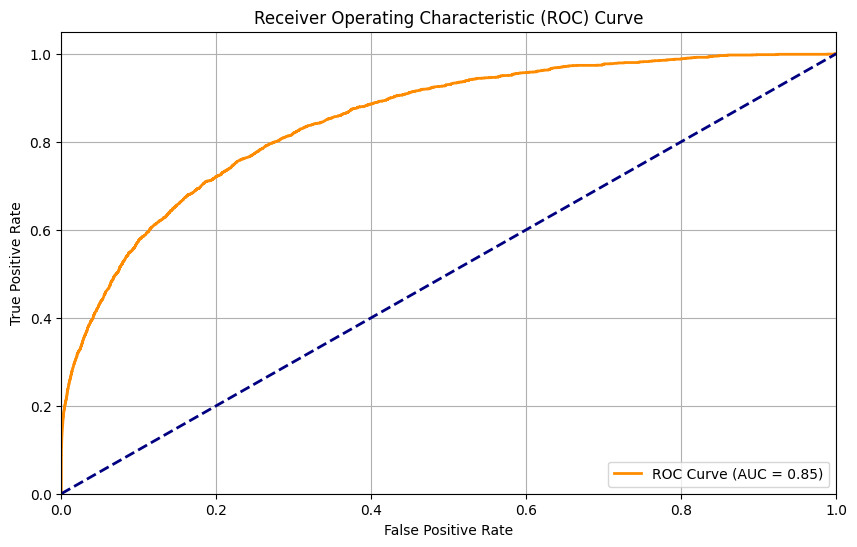

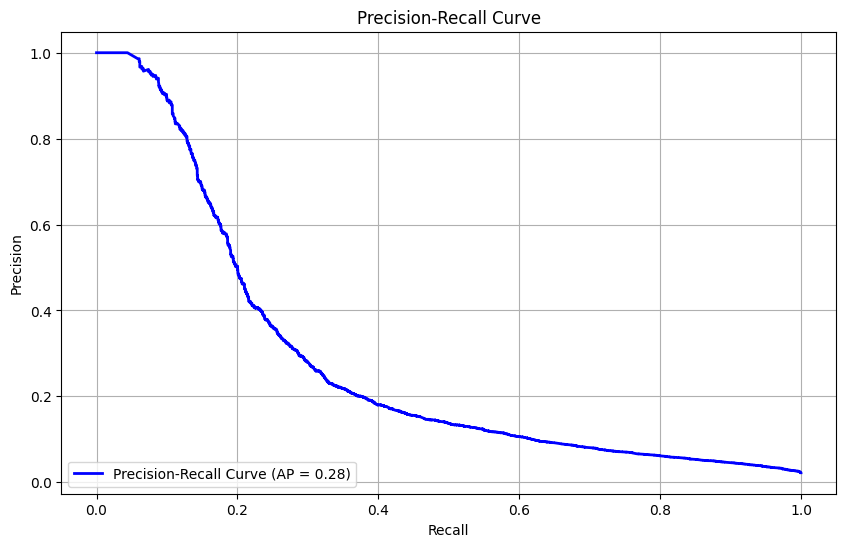

Average Precision Score: 0.2791


In [30]:
fpr, tpr, _ = roc_curve(y_test, y_final_prob)
roc_auc = auc(fpr, tpr)

# Step 2: Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 3: Compute Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_final_prob)
avg_precision = average_precision_score(y_test, y_final_prob)

# Step 4: Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Step 5: Print Average Precision Score
print(f"Average Precision Score: {avg_precision:.4f}")

# Calibrated Classifier Model

In [31]:
#Use selected features from Lasso regression
selected_features = np.where(lasso.coef_ != 0)[0]

X_train_selected = X_train_combined[:, selected_features]
X_test_selected = X_test_combined[:, selected_features]

voting_model.fit(X_train_selected, y_train)

calibrated_model = CalibratedClassifierCV(voting_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_selected, y_train)

y_final_prob_calibrated = calibrated_model.predict_proba(X_test_selected)[:, 1]

final_calibrated_auc = roc_auc_score(y_test, y_final_prob_calibrated)
print(f"Calibrated Model ROC-AUC Score: {final_calibrated_auc:.4f}")


Calibrated Model ROC-AUC Score: 0.8497


In [32]:
brier_score = brier_score_loss(y_test, y_final_prob_calibrated)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.0207


In [33]:
log_loss_score = log_loss(y_test, y_final_prob_calibrated)
print(f"Log-Loss: {log_loss_score:.4f}")

Log-Loss: 0.0969


In [40]:
voting_model = LogisticRegression(solver='saga', max_iter=1000, C=0.1, warm_start=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('calibrated_classifier', CalibratedClassifierCV(voting_model, cv='prefit'))
])

param_grid = {
    'calibrated_classifier__method': ['sigmoid', 'isotonic'],
    'calibrated_classifier__cv': [3, 5, 10]
}

calibrated_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit the model
calibrated_search.fit(X_train_selected, y_train)

# Get the best calibrated model
best_calibrated_model = calibrated_search.best_estimator_

# Make predictions and evaluate ROC-AUC score
y_best_prob_calibrated = best_calibrated_model.predict_proba(X_test_selected)[:, 1]
best_roc_auc_calibrated = roc_auc_score(y_test, y_best_prob_calibrated)

# Print the best ROC-AUC score
print(f"Best ROC-AUC for Calibrated Model: {best_roc_auc_calibrated:.4f}")


Best ROC-AUC for Calibrated Model: 0.7974


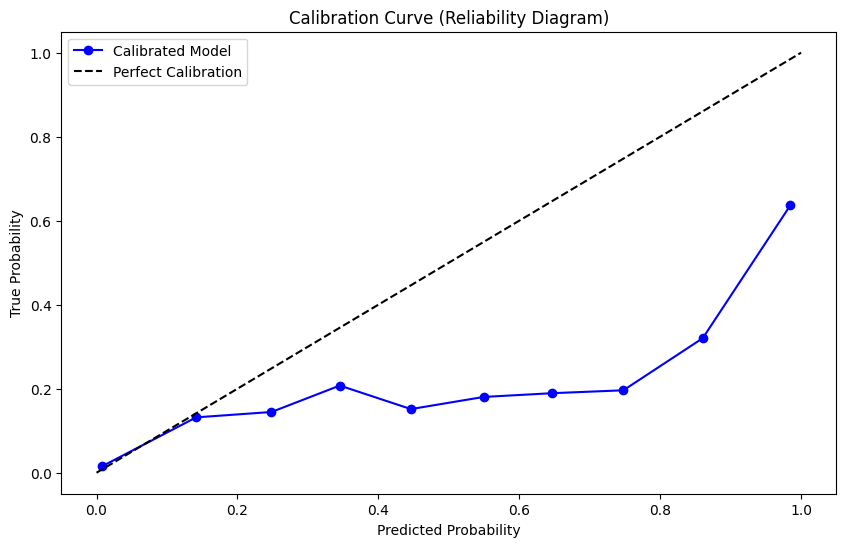

In [41]:
prob_true, prob_pred = calibration_curve(y_test, y_final_prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', color='b', label='Calibrated Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.show()

In [52]:
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

for i, (train_index, test_index) in enumerate(outer_cv.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
for i, (train_index, test_index) in enumerate(inner_cv.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[     0      1      2 ... 531483 531484 531485]
  Test:  index=[    12     13     18 ... 531472 531473 531477]
Fold 1:
  Train: index=[     0      1      3 ... 531477 531481 531482]
  Test:  index=[     2      8      9 ... 531483 531484 531485]
Fold 2:
  Train: index=[     0      1      2 ... 531483 531484 531485]
  Test:  index=[     4     22     33 ... 531463 531467 531481]
Fold 3:
  Train: index=[     0      2      4 ... 531483 531484 531485]
  Test:  index=[     1      3      5 ... 531470 531471 531482]
Fold 4:
  Train: index=[     1      2      3 ... 531483 531484 531485]
  Test:  index=[     0      6      7 ... 531451 531474 531475]
Fold 5:
  Train: index=[     0      1      2 ... 531483 531484 531485]
  Test:  index=[     8     14     25 ... 531479 531480 531482]
Fold 6:
  Train: index=[     0      2      3 ... 531483 531484 531485]
  Test:  index=[     1      4     16 ... 531472 531478 531481]
Fold 7:
  Train: index=[     0      1      2 ... 531481 531482